# Learning PageRank

### Overview

This Jupyter Notebook covers the **implementation of two simple Graph Neural Networks** (GNN) that are able to learn and determine the PageRank value of a graph.

As such, the repository covers:
- A program to compute the PageRank value of a given graph
- A random graph generator based on Erdos' random graph and scale-free generation
- A GNN with relaxation
- A GNN with a convolutional graph approach

The python implementations are available in the `script` folder and will be imported in this notebook. 

#### Note & Citation

This notebook relies heavily on the `networkx` library:

> Aric A. Hagberg, Daniel A. Schult and Pieter J. Swart, “Exploring network structure, dynamics, and function using NetworkX”, in Proceedings of the 7th Python in Science Conference (SciPy2008), Gäel Varoquaux, Travis Vaught, and Jarrod Millman (Eds), (Pasadena, CA USA), pp. 11–15, Aug 2008

### Library imports

In [14]:
import networkx as nx
import numpy as np

from scripts.dataset import generate_graph_dataset
from scripts.functions import generate_erdos_graph, generate_scale_free_graph
from scripts.functions import plot_graph
from scripts.page_rank import page_rank
from scripts.random_graph_generator import Random_Graph_Generator

%matplotlib inline

## 1. Implementing a Custom PageRank Function

### 1.1. The Concept of PageRank

#### Overview

PageRank or $PR$ is an link analysis algorithm used by Google to rank web pages. 

Considering pages as node of a (web)graph, hyperlinks or references between pages are considered as edges of said graph. The PageRank of a node is the numerical weight representing the importance of the node in the graph, which is computed by the number of incoming link to the node existing within the graph itself. 

> Page, Lawrence and Brin, Sergey and Motwani, Rajeev and Winograd, Terry (1999) The PageRank Citation Ranking: Bringing Order to the Web. Technical Report. Stanford InfoLab.

#### Overview of the Algorithm

The PageRank algorithm is recursive as any PageRank value of a node of a graph is derived from the PageRank values of other nodes. 

<u>Initialization:</u>

Given a graph $G$ with nodes $\forall i\in\{0,1,\ldots,n\}, N_i\in G$. Edges corresponds to links between each nodes (no node self-references). Each node is initialized with a PageRank value drawn from a probability distribution with domain $[0,1]$ and summing to 1. 

A node $N_i$ transfers its PageRank value to the node $N_j$ it references (i.e. via an outbound link $N_i\rightarrow N_j$). The value transfer is done in equal proportion between each link $\forall j\in\{0,\ldots,n\},i\neq j, N_i\rightarrow N_j$. 

<u>Page Rank computation:</u>

As such, the PageRank amount granted to a node $N_j$ from a node $N_i$ via an outbound link $N_i\rightarrow N_j$ is:

$\forall i, j\in\{0,1,\ldots,n\},i\neq j,$
\begin{align}
N_i, N_j&\in G\\
PR_{\text{transferred},\,N_i\rightarrow N_j}(N_i)&=\frac{PR(N_i)}{L(N_i)}\\
L(N_i)&=\overset{n}{\underset{i=0\\i\neq j}{\sum}}\mathbb{1}_{\exists N_i\rightarrow N_j}
\end{align}

Consequently, the PageRank value of a single node $N_i$ is:

$$\forall i, j\in\{0,1,\ldots,n\},i\neq j,\,PR(N_i)=\frac{1-d}{n}+d\big(\overset{n}{\underset{j\in\mathcal{M}(i)}{\sum}}PR_{\text{transferred},\,N_j\rightarrow N_i}(N_j)\big)$$

With $\mathcal{M}(i)$ the set of nodes $N_j$ that link to node $N_i$, $d$ a damping vactor (often set to $0.85$) that captures the idea that a random walker on the web will continue clicking on links on a page/node as a reducing rate.

#### Note on PageRank and Message Passing Models

We find some similarities between the way PageRank is computed and a generic model description of Graph Neural Networks based on message exchange among neighbors. Many GNN models can be described using this formalism called *Message Passing*, which helps understand how information propagates within a graph.

<center><img src="assets/message_passing.gif" width="400"></center>

### 1.2. Iterative Implementation

We decide to implement PageRank's iterative method described as such:

#### Initialization

- $n$, the number of nodes in the graph
- $t=0$, the starting timestep
- $\forall i\in\{0, \ldots, n\},\,PR(N_i; t=0)=\frac{1}{n}$, the starting PageRank of a node $N_i$ at time $t=0$
- $d\in[0, 1]$, the damping factor (usually set to $0.85$)
- $\epsilon$, an error parameter used to stop the algorithm

#### Iterative Steps

At each time step,

\begin{align}
\forall i\in\{0, \ldots, n\},\,PR(N_i; t+1)&=\frac{1-d}{n}+d\big(\overset{n}{\underset{j\in\mathcal{M}(i)}{\sum}}\frac{PR(N_j)}{L(N_j)}\big)\\
\end{align}

We denote $R(t)$ the column vector of length $n$ which row values are $\forall i \in \{0, \ldots, n\}, PR(N_i; t)$.

#### Iteration Stop

The above iterative process stops when: $$|R(t+1)-R(t)|<\epsilon$$

This assumes that the process has converged.

#### Example implementation

The full code is avalaible in the file `scripts/page_rank.py`.

In [15]:
# Generates a probabilistic transition matrix M
# of a graph with 10 nodes
M = np.random.random(size=(10, 10))
N = np.random.randint(0, 2, size=(10, 10))
M = M*N # adds zeros
M = M/M.sum(axis=0) # sums columns to one

print("Transition matrix M:\n", np.round(M, 1))

Transition matrix M:
 [[0.  0.2 0.1 0.1 0.  0.2 0.2 0.  0.2 0. ]
 [0.  0.  0.  0.2 0.2 0.2 0.  0.3 0.  0.1]
 [0.4 0.1 0.  0.  0.  0.  0.  0.1 0.  0. ]
 [0.1 0.1 0.  0.1 0.  0.  0.1 0.3 0.  0. ]
 [0.  0.  0.  0.1 0.1 0.1 0.  0.  0.  0.2]
 [0.1 0.2 0.2 0.1 0.  0.  0.  0.  0.  0.3]
 [0.  0.  0.  0.  0.3 0.3 0.  0.2 0.3 0.3]
 [0.  0.  0.4 0.  0.  0.1 0.1 0.  0.  0. ]
 [0.2 0.3 0.  0.2 0.4 0.  0.3 0.1 0.  0. ]
 [0.2 0.  0.3 0.2 0.  0.  0.3 0.  0.5 0. ]]


In [16]:
# Computes the PageRank of each of the 10 nodes
page_rank(M, print_convergence=True)

PageRank converged at iteration 10 with epsilon=1e-05.


array([[0.09919386],
       [0.09485379],
       [0.05963081],
       [0.07442367],
       [0.06339439],
       [0.10265148],
       [0.15649388],
       [0.06421995],
       [0.13308349],
       [0.15205467]])

## 2. Generating Random Graphs

### 2.1. Generating an Example Erdos Graph

In [17]:
g = generate_erdos_graph(10, 0.3)

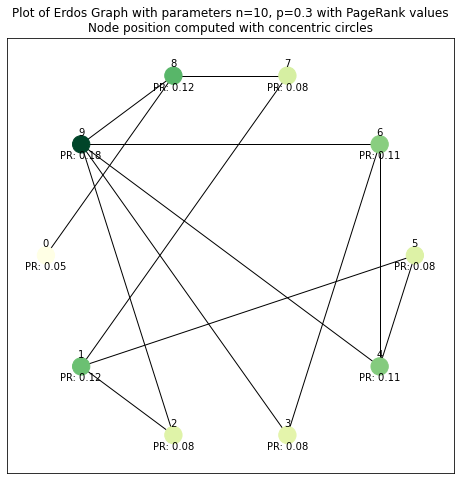

In [18]:
plot_graph(g, layout="shell")

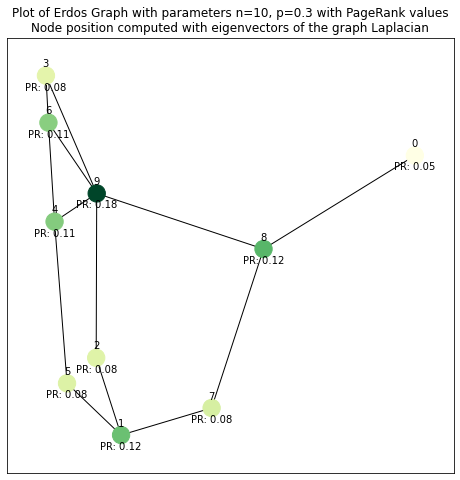

In [19]:
plot_graph(g, layout="spectral")

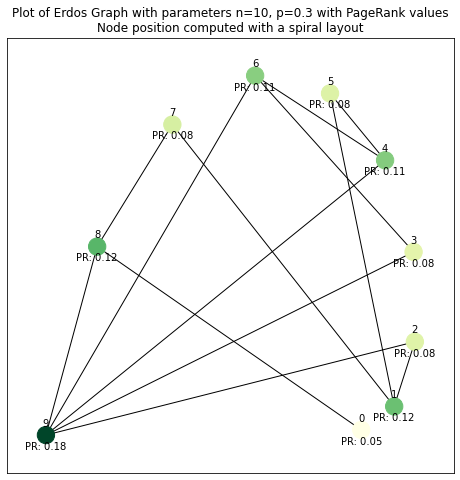

In [20]:
plot_graph(g, layout="spiral")

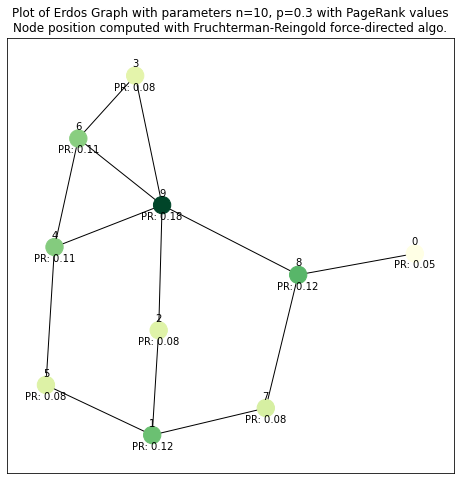

In [21]:
plot_graph(g, layout="spring")

### 2.2. Generating an Example Scale-Free Graph

In [22]:
g = generate_scale_free_graph(10)

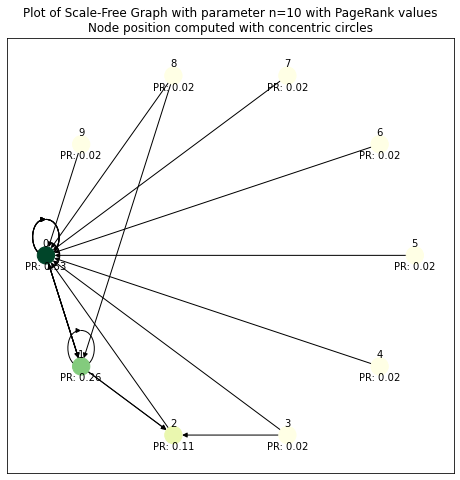

In [23]:
plot_graph(g, layout="shell")

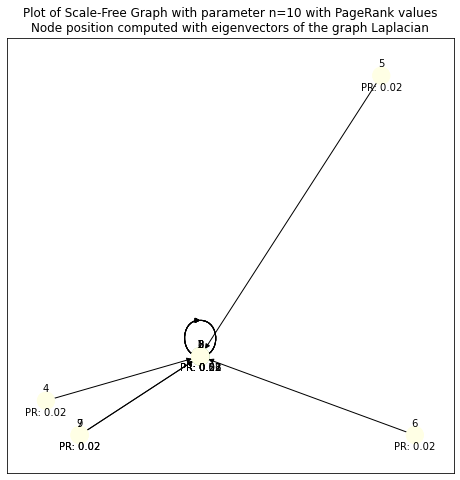

In [24]:
plot_graph(g, layout="spectral")

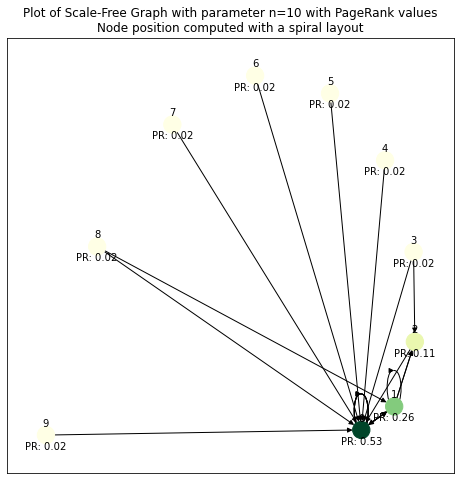

In [25]:
plot_graph(g, layout="spiral")

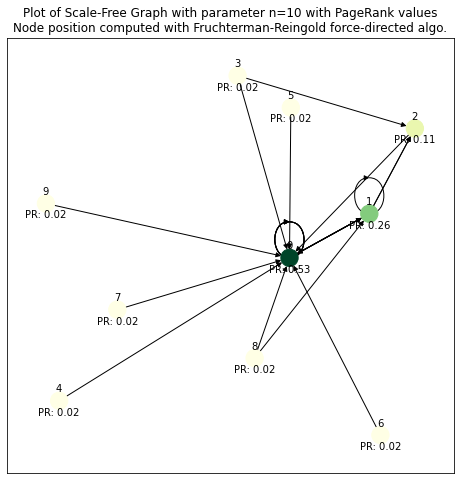

In [26]:
plot_graph(g, layout="spring")

### 2.2. Many Graphs Generation

#### Erdos' Method

The Erdős-Rényi graph or a binomial graph is a graph model that construct a graph $G_{n,p}$ where each of the possible edges between $n$ nodes appear with a fixed probability $p$. Each edge's probability of appearance is independent from the other edge's own probabilities.

> P. Erdős and A. Rényi, On Random Graphs, Publ. Math. 6, 290 (1959).

<u>Example</u>

In [27]:
erdos_generator = Random_Graph_Generator("erdos", True)
erdos_generator.graphs_generate(2000, 5, 0.5)
erdos_generator.graphs_page_rank_compute()
eX, ey = erdos_generator.graphs_retrieve()

Erdos Graph Generator declared
5 graphs were generated
PageRank values computed


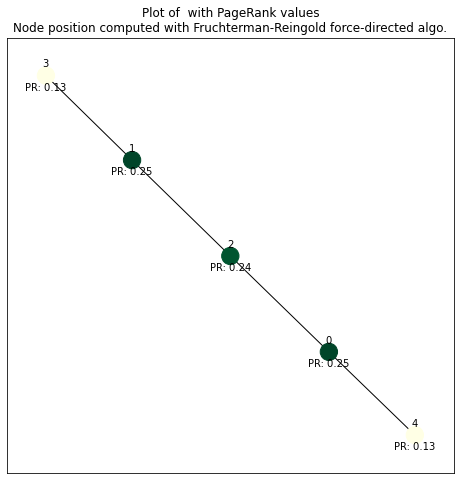

{0: 0.24594541923542018,
 1: 0.24594541923542018,
 2: 0.2390545807645797,
 3: 0.13452729038228986,
 4: 0.13452729038228986}

In [28]:
plot_graph(eX[1000])
ey[1000]

#### Scale-Free Method

The Scale-Free graph is a graph model that construct a graph $G_{n}$ of $n$ nodes with the property that the number of links $k$ originating from a given node exhibits a power law distribution $P(k)\sim k^(-\gamma)$. 

A scale-free network can be constructed by progressively adding nodes to an existing network and introducing links to existing nodes with preferential attachment so that the probability of linking to a given node $i$ is proportional to the number of existing links $k_i$ that node has such that:

$$P(\text{linking to node }i)\sim\frac{k_i}{\sum_jk_j}$$

> B. Bollobás, C. Borgs, J. Chayes, and O. Riordan, Directed scale-free graphs, Proceedings of the fourteenth annual ACM-SIAM Symposium on Discrete Algorithms, 132--139, 2003.

<u>Example</u>

In [29]:
scalefree_generator = Random_Graph_Generator("scale-free", True)
scalefree_generator.graphs_generate(2000, 5)
scalefree_generator.graphs_page_rank_compute()
sfX, sfy = scalefree_generator.graphs_retrieve()

Scale-Free Graph Generator declared
5 graphs were generated
PageRank values computed


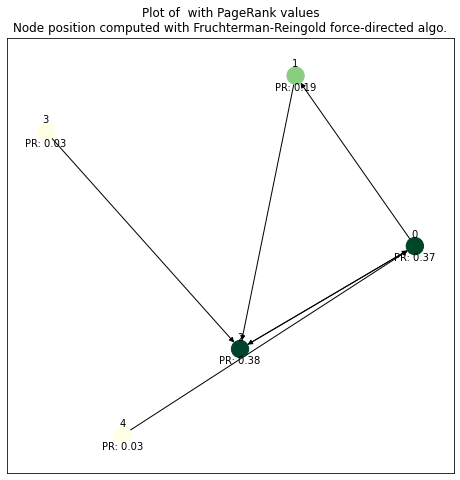

{0: 0.3749010498436535,
 1: 0.18933258929540883,
 2: 0.3757663608609381,
 3: 0.030000000000000006,
 4: 0.030000000000000006}

In [30]:
plot_graph(sfX[1000])
sfy[1000]

## 3. Learning PageRank

### 3.1. Building a Dataset
    
<u>Parameter selection</u>

To construct a dataset, we select:

- A **range of nodes $N$** to modulate the number of nodes in the graphs we want to create
- A selection of **graph-generating methods**. In our case: 
    - Erdos' method
    - Scale-Free method
- A **range of parameter values** for each parameter used to generate the graphs. In our case:
    - A range of probabilities $P$ to generate Erdos graphs
- A **number of graphs** to generate $n_{method}$ ***per given case and method***. In our case:
    - Erdos' method: we will obtain $n_{\text{erdos}}*len(P)*len(N)$
    - Scale-Free method: we will obtain $n_{\text{scale-free}}*len(N)$

As such, we choose to generate 50,000 graphs, emulating the MNIST format with the following parameters, ending with a 50/50 split between Erdos and Scale-Free graphs:

| Parameters | Description | Value | 
| :---: | :---: | :---: |
| P | Range of probabilities to generate Erdos graphs | {0.2, 0.3, 0.4, 0.5} |
| N |  Range of nodes to generate graphs |  {10, 25, 50, 75, 100} |
| $n_{\text{erdos}}$ | Number of Erdos graphs to generate per case | 25 | 
| $n_{\text{scale-free}}$ | Number of Scale-Free graphs to generate per case | 100 |


In [111]:
# Declares the parameters

P            = [0.2, 0.3, 0.4, 0.5]
N            = [5, 10, 25, 50, 100]
n_erdos      = 25
n_scale_free = 100

<u>Building the dataset</u>

We build 1,000 graphs each with a PageRank value per node, resulting in `25*5*(5+10+25+50+100)+100*(5+10+25+50+100)` nodes, i.e. 42750 nodes, and on average c. 300,000 to 400,000 edges.

In [112]:
X, y = generate_graph_dataset(P, N, n_erdos, n_scale_free)

Generating Erdos graphs with parameters:
	Completed -- n=10, p=0.2
	Completed -- n=25, p=0.2
	Completed -- n=50, p=0.2
	Completed -- n=75, p=0.2
	Completed -- n=100, p=0.2
	Completed -- n=10, p=0.3
	Completed -- n=25, p=0.3
	Completed -- n=50, p=0.3
	Completed -- n=75, p=0.3
	Completed -- n=100, p=0.3
	Completed -- n=10, p=0.4
	Completed -- n=25, p=0.4
	Completed -- n=50, p=0.4
	Completed -- n=75, p=0.4
	Completed -- n=100, p=0.4
	Completed -- n=10, p=0.5
	Completed -- n=25, p=0.5
	Completed -- n=50, p=0.5
	Completed -- n=75, p=0.5
	Completed -- n=100, p=0.5

Generating Scale-Free graphs with parameter:
	Completed -- n=10
	Completed -- n=25
	Completed -- n=50
	Completed -- n=75
	Completed -- n=100


In [113]:
print(len(X), len(y))

1000 1000


In [114]:
print("Adjacency matrix of 0th graph:",
      nx.adjacency_matrix(X[0]).todense(),
      "\nPageRank values per node of 0th graph:",
      y[0],
      sep="\n")

Adjacency matrix of 0th graph:
[[0 1 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 1]
 [0 1 0 0 1 0 1 0 1 0]]

PageRank values per node of 0th graph:
{0: 0.11791989566779466, 1: 0.17509709976217458, 2: 0.01807228915662651, 3: 0.11820522652371111, 4: 0.06745009617195223, 5: 0.01807228915662651, 6: 0.06745009617195223, 7: 0.06768258010432622, 8: 0.11768741173542066, 9: 0.2323630155494153}


### 3.2. Building Two Graph Neural Networks

<u>GNN with relaxation</u>

<u>Convolutional GNN</u>

### 3.3. Training the Graph Neural Networks

<u>GNN with relaxation</u>

<u>Convolutional GNN</u>

## 4. Discussing the Results

In [ ]:
https://github.com/HusseinLezzaik/Graph-Neural-Networks/blob/main/Make_your_own_dataset.py#

!pip install dgl==0.6.1
!pip install torch==1.9.1
import dgl

In [35]:
X[0]

In [51]:
g = dgl.from_networkx(X[0])
dir(g)

['__class__',
 '__contains__',
 '__copy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batch_num_edges',
 '_batch_num_nodes',
 '_canonical_etypes',
 '_dsttypes_invmap',
 '_edge_frames',
 '_etype2canonical',
 '_etypes',
 '_etypes_invmap',
 '_find_etypes',
 '_get_e_repr',
 '_get_n_repr',
 '_graph',
 '_idtype_str',
 '_init',
 '_is_unibipartite',
 '_node_frames',
 '_ntypes',
 '_pop_e_repr',
 '_pop_n_repr',
 '_reset_cached_info',
 '_set_e_repr',
 '_set_n_repr',
 '_srctypes_invmap',
 'add_edge',
 'add_edges',
 'add_nodes',
 'add_self_loop',
 'adj',
 'adjacency_matrix',
 'adjacency_matrix_scipy',
 'all_edges',
 'apply_edges',
 'apply_node

In [60]:
g.num_nodes()

5

In [2]:
import networkx as nx
import dgl

In [46]:
class SyntheticDataset(DGLDataset):
    def __init__(self, graphs, pageranks):
        super().__init__(name='synthetic')
        self.graph_raws = graphs
        self.page_rank_vals = pageranks

    def process(self):
        self.graphs = []
        self.page_ranks = []

        # Create a graph for each graph ID from the edges table.
        # First process the properties table into two dictionaries with graph IDs as keys.
        # The label and number of nodes are values.
        page_ranks_dict = {}
        num_nodes_dict  = {}
        for num_graph, graph in enumerate(self.graph_raws):
            page_ranks_dict[num_graph] = self.page_rank_vals[num_graph]
            num_nodes_dict[num_graph]  = graph.num_nodes()
#         for _, row in properties.iterrows():
#             label_dict[row['graph_id']] = row['label']
#             num_nodes_dict[row['graph_id']] = row['num_nodes']

#         # For the edges, first group the table by graph IDs.
#         edges_group = edges.groupby('graph_id')
            src =       graph.edges()[0].numpy()
            dst =       graph.edges()[1].numpy()
            num_nodes = graph.num_nodes()
            pagerank  = self.page_rank_vals[num_graph]

        # For each graph ID...
        for graph_id in edges_group.groups:
            # Find the edges as well as the number of nodes and its label.
            edges_of_id = edges_group.get_group(graph_id)
            src = edges_of_id['src'].to_numpy()
            dst = edges_of_id['dst'].to_numpy()
            num_nodes = num_nodes_dict[graph_id]
            label = label_dict[graph_id]

            # Create a graph and add it to the list of graphs and labels.
            g = dgl.graph((src, dst), num_nodes=num_nodes)
            self.graphs.append(g)
            self.labels.append(label)

        # Convert the label list to tensor for saving.
        self.labels = torch.LongTensor(self.labels)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

dataset = SyntheticDataset(X, y)
graph, label = dataset[0]
print(graph, label)
    

In [5]:
# load data
dataset = dgl.data.CiteseerGraphDataset(raw_dir='')
graph = dataset[0]

# get split masks
train_mask = graph.ndata['train_mask']
val_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']

# get node features
feats = graph.ndata['feat']

# get labels
labels = graph.ndata['label']


Finished data loading and preprocessing.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


/home/quentin/anaconda3/envs/ML_base/lib/python3.9/site-packages/dgl/data/citation_graph.py:273: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


In [43]:
?DGLBuiltinDataset

In [63]:
X[0].edges

EdgeView([(1, 3), (1, 4)])

In [64]:
X[0].nodes

NodeView((0, 1, 2, 3, 4))

In [65]:
X[1].edges

EdgeView([(0, 4), (3, 4)])

In [66]:
X[1].nodes

NodeView((0, 1, 2, 3, 4))

In [71]:
nx.compose(X[0], X[1]).edges

EdgeView([(0, 4), (1, 3), (1, 4), (3, 4)])

In [69]:
nx.compose(X[0], X[1]).edges

EdgeView([(0, 4), (1, 3), (1, 4), (3, 4)])

In [73]:
?nx.compose

In [92]:
test = nx.set_node_attributes(X[0], y[0], "labels")

In [95]:
X[0].nodes()[0]

{'labels': 0.04545454545454546}

In [100]:
nx.disjoint_union(X[0], X[1]).nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9))

In [118]:
len(g.edges)

325806